In [1]:
### Importing Required Libraries

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from numpy import array, asarray, zeros
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, LSTM, Flatten, Dense
from keras.layers.core import Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#load the dataset

df=pd.read_csv(r'C:\Users\sunan\Desktop\Projects\IMDB Sentiment\IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df.columns.isna().sum()

0

In [4]:
df.shape

(50000, 2)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

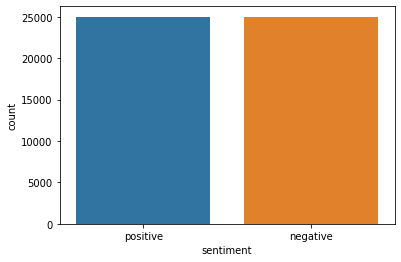

In [5]:
sns.countplot(x = 'sentiment', data =df)

In [6]:
import random
randomlist = [random.randint(1,len(df.review)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[randomlist,:].head(10) # Returns the rows with the index and display it

,review,sentiment
14738,"In the questionable comedy vein of Mel Brooks,...",negative
22863,Unlike some movies which you can wonder around...,positive
47343,I can't quite explain why I find this so allur...,positive
35409,To suggest Anton Newcombe of the Brian Jonesto...,positive
10104,"I wasn't expecting ""Citizen Kane"" but I was ho...",negative
24441,I've had a lot of experience with women in Rus...,positive
8961,"In all my 60 years of age, I have learned that...",positive
29744,"It is such a strange movie, you can call it aw...",negative
39228,"Joan Fontaine is ""A Damsel in Distress"" in thi...",positive
44976,I have a piece of advice for the people who ma...,negative


In [7]:
#preprocessing the data


def data_cleaning(text):
    text = str(text).lower()  # convert to lowercase
    text = re.sub(pattern=r'\s+[a-zA-Z]\s+',repl='',string = text)   # remove single characters
    text = re.sub(r'https?://\S+|www\.\S+',repl='',string = text)   # Remove URls, whitespace characters 
    text = re.sub(r'[^a-z\s]',' ',string = text)# Removes all the special characters, digits from 0-9 and Capital Letters
    text = re.sub(r'\s+', ' ', string = text)  # Substituting multiple spaces with single space
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text.split() if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [8]:
df.review = df.review.apply(lambda x: data_cleaning(x))

In [11]:
df

,review,sentiment
0,one review mention watch oz episod hook right ...,positive
1,wonder littl product br br film techniqu unass...,positive
2,thought waswond way spend time ontoo hot summe...,positive
3,basic sfamili wherelittl boy jake think szombi...,negative
4,petter mattei love time money isvisu stun film...,positive
...,...,...
49995,thought movi diddown right good job creativ or...,positive
49996,bad plot bad dialogu bad act idiot direct anno...,negative
49997,amcathol taught parochi elementari school nun ...,negative
49998,go disagre previou comment side maltin one iss...,negative


In [12]:
max_no_words = 5000
max_sequence_length = 30

In [13]:
#data Splitting: train, test

train_data, test_data = train_test_split(df, test_size=0.20,random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 40000
Test Data size 10000


In [14]:
train_data.head(10)

,review,sentiment
25164,anoth must film henri brandon isfavorit surpri...,positive
37366,timeev actual laugh watch show make fun jami l...,negative
24912,bad act br br forbunch castaway alien planet s...,negative
7345,german think smirk funni like american think m...,negative
28620,certainli one time fav episod trek much go one...,positive
4267,expectlot ghost stori butdo expectstori makebi...,negative
40891,string attach featur carlo mencia stand make u...,positive
26038,iscatastroph movi set london start multipl hur...,positive
26159,first foremost movi stupidest plot moviehav ev...,negative
24458,like dylan moran work black book althoughfound...,positive


In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.review)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 167726


In [36]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.review),
                        maxlen = max_sequence_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.review),
                       maxlen = max_sequence_length)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (40000, 30)
Testing X Shape: (10000, 30)


In [37]:
train_data.sentiment.unique().tolist()

['positive', 'negative']

In [38]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

LabelEncoder()

In [39]:
y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (40000, 1)
y_test shape: (10000, 1)


In [40]:
## Embedding Layer

In [41]:
glv_emb = open(r'C:\Users\sunan\Desktop\Projects\Sentiment analysis(chunks)\Amazon Food Review Analysis\Glove Embedding\glove.6B.100d.txt', encoding='utf8')

In [42]:
LR = 1e-3
EMBEDDING_DIM = 100
BATCH_SIZE = 1024
EPOCHS = 10

In [43]:
embeddings_index = {}

for line in glv_emb:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
        
glv_emb.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [44]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [45]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19788   ,  0.25264999, -0.28308001, ..., -0.44062999,
        -0.74264997, -0.3215    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [46]:
import tensorflow as tf
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

In [47]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

In [48]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 100)           16772600  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 16,889,977
Trainable params: 117,377
Non-trainable params: 16,772,600
_________________________________________________________________


In [50]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
40/40 [==============================] - 39s 916ms/step - loss: 0.6208 - acc: 0.6510 - val_loss: 0.5946 - val_acc: 0.6814
Epoch 2/10
40/40 [==============================] - 38s 944ms/step - loss: 0.5688 - acc: 0.7023 - val_loss: 0.5531 - val_acc: 0.7165
Epoch 3/10
40/40 [==============================] - 39s 978ms/step - loss: 0.5459 - acc: 0.7188 - val_loss: 0.5660 - val_acc: 0.7044
Epoch 4/10
40/40 [==============================] - 39s 970ms/step - loss: 0.5288 - acc: 0.7321 - val_loss: 0.5265 - val_acc: 0.7367
Epoch 5/10
40/40 [==============================] - 40s 995ms/step - loss: 0.5071 - acc: 0.7462 - val_loss: 0.5221 - val_acc: 0.7380
Epoch 6/10
40/40 [==============================] - 39s 983ms/step - loss: 0.4964 - acc: 0.7551 - val_loss: 0.5063 - val_acc: 0.7489
Epoch 7/10
40/40 [==============================] - 39s 978ms/step - loss: 0.4816 - acc: 0.7617 - val_loss: 0.5496 - val_acc: 0.7306
Epoch 8/10
40/40 [==============================] - 42s 1s/step - los

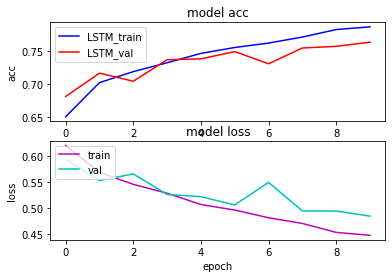

In [52]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['acc'], c= 'b')
at.plot(history.history['val_acc'], c='r')
at.set_title('model acc')
at.set_ylabel('acc')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [58]:
def predictions(text):
    review = tokenizer.texts_to_sequences(text)
    review_padded = pad_sequences(
        review,
        padding = 'post',
        maxlen = max_sequence_length
    )
    pred = model.predict(review_padded)
    return 'Positive' if pred[0] >= 0.5 else 'Negative'

In [59]:
####### Predict 

In [63]:
#load the dataset

test_df=pd.read_csv(r'C:\Users\sunan\Desktop\Projects\IMDB Sentiment\IMDB Dataset.csv')
test_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [65]:
predictions([test_df.iloc[100].review])

'Negative'

In [67]:
print([test_df.iloc[100].review])

["This short film that inspired the soon-to-be full length feature - Spatula Madness - is a hilarious piece that contends against similar cartoons yielding multiple writers. The short film stars Edward the Spatula who after being fired from his job, joins in the fight against the evil spoons. This premise allows for some funny content near the beginning, but is barely present for the remainder of the feature. This film's 15-minute running time is absorbed by some odd-ball comedy and a small musical number. Unfortunately not much else lies below it. The plot that is set up doesn't really have time to show. But it's surely follows it plot better than many high-budget Hollywood films. This film is worth watching at least a few times. Take it for what it is, and don't expect a deep story."]
